# Natural Language Processing with Amazon Reviews

Developed for the second project of the Artificial Intelligence course

## Setup and Environment

After installing Python and the necessary packages, run the following code to import them:## Implementation work

### Loading the data

In [3]:
%matplotlib inline

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sb
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/bruno/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Implementation work

### Loading the data

In [5]:
train = pd.read_csv('./data/train.csv').sample(1000)
test = pd.read_csv('./data/test.csv').sample(216)
train.head()


,class_index,review_title,review_text
1385947,4,Great Disc,This lite up disc is very nice. Very easy to f...
2263517,4,Queen is King,Listening to this cd makes me think of the gre...
1981043,2,Great until they break!,Many other well written bits. Good sound quali...
2106778,5,Mag-lite Holster,I have a LED AA maglite which is longer than t...
2433123,5,How do you review RAM?,I don't know how you would go about reviewing ...


### Searching for null values

In [6]:
print("Columns with empty review text", len(train.loc[train['review_text'] == ""]))
print("Columns with missing review text", len(train.loc[train['review_text'] == None]))

print("Columns with empty review title", len(train.loc[train['review_title'] == ""]))
print("Columns with missing review title", len(train.loc[train['review_title'] == None]))

print("Columns with empty class index", len(train.loc[train['class_index'] == ""]))
print("Columns with missing class index", len(train.loc[train['class_index'] == None]))

Columns with empty review text 0
Columns with missing review text 0
Columns with empty review title 0
Columns with missing review title 0
Columns with empty class index 0
Columns with missing class index 0


As we can see, the dataset does not contain any empty or missing values

### Studying the data

<AxesSubplot:>

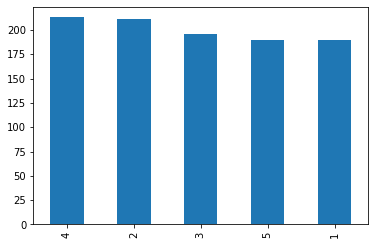

In [7]:
train['class_index'].value_counts().plot(kind='bar')

As the dataset creators have told us, the training dataset consists of 600 thousand samples for each review score, from 1 to 5.

##### Most frequent Words

/home/bruno/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0.5, 0, 'Words'), Text(0, 0.5, 'Occurrencies')]

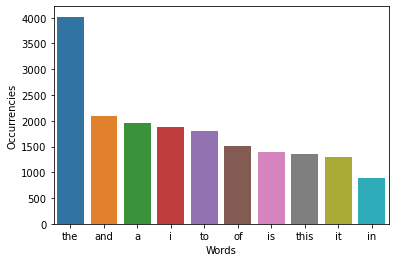

In [8]:
from collections import Counter

mostUsed = pd.Series(' '.join(train['review_text']).lower().split()).value_counts()[:10]
mostUsedGraph = sb.barplot(mostUsed.index, mostUsed.values)
mostUsedGraph.set(xlabel="Words", ylabel="Occurrencies")

### Treating the data
##### Cleanup and Normalization

In [9]:
ps = PorterStemmer()

def normalize(text):
    # remove non alpha chars
    text = re.sub('[^a-zA-Z]', ' ', text)
    # to lower-case and tokenize
    text = text.lower().split()
    # stemming and stop word removal
    text = ' '.join([ps.stem(w) for w in text if not w in set(stopwords.words('english'))])

    return text

train['review_text'] = train['review_text'].apply(normalize)
train['review_title'] = train['review_title'].apply(normalize)
train.head()

test['review_text'] = test['review_text'].apply(normalize)
test['review_title'] = test['review_title'].apply(normalize)

##### Saving Preprocessed data
Since the original dataset is very large, we can sample it and save the preprocessed data in a different csv file, so it can be used later.

In [10]:
def savePreprocessedData(dataSet, fileName):
    dataSet.to_csv(fileName, index=False)

savePreprocessedData(train, './data/train_preprocessed.csv')
savePreprocessedData(test, './data/test_preprocessed.csv')

##### Generating wordclouds
A visually appealing way of observing words in a dataset is by showing wordclouds. In order to make a single wordcloud for a whole column, we can join all the cells together. We then pass it to WordCloud to generate a wordcloud: it will automatically assign weights to words based on the number of occurrences of each word.

These are the most common words in the reviews' titles:

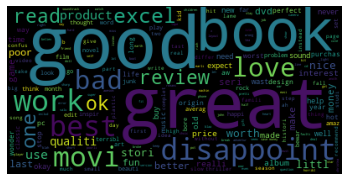

In [11]:
wordcloudTitle = WordCloud().generate(" ".join([str(x) for x in train['review_title'].values]))

plt.figure()
plt.imshow(wordcloudTitle)
plt.axis('off')
plt.show()


These are the most common words in the reviews' titles:

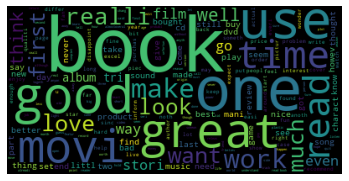

In [12]:
wordcloudText = WordCloud().generate(" ".join([str(x) for x in train['review_text'].values]))

plt.figure()
plt.imshow(wordcloudText)
plt.axis('off')
plt.show()

It would also be interesting to visualize a wordcloud for each of the reviews' classes (1 to 5):

Word cloud for class 1's titles:


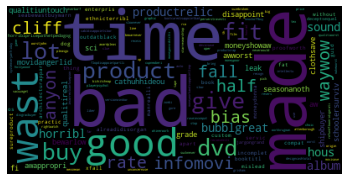

Word cloud for class 1's text:


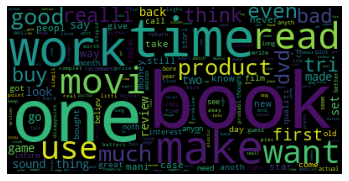

Word cloud for class 2's titles:


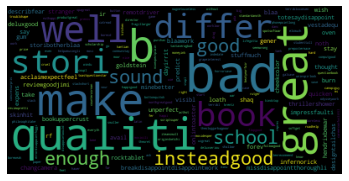

Word cloud for class 2's text:


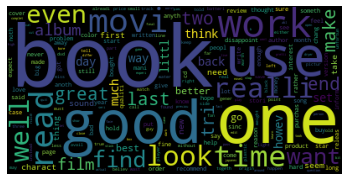

Word cloud for class 3's titles:


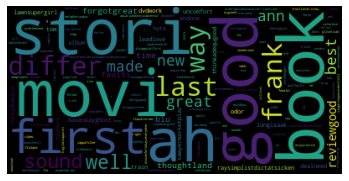

Word cloud for class 3's text:


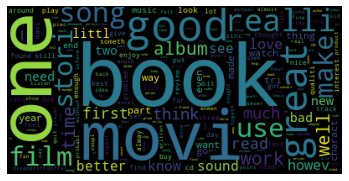

Word cloud for class 4's titles:


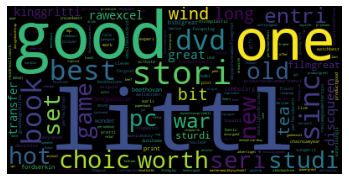

Word cloud for class 4's text:


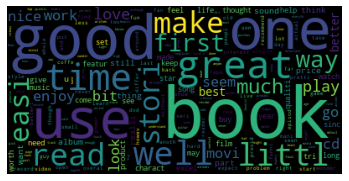

Word cloud for class 5's titles:


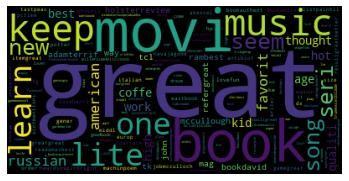

Word cloud for class 5's text:


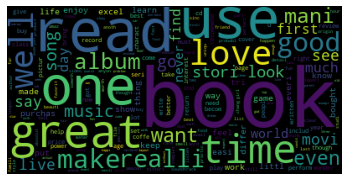

In [23]:
wordsPerClass = {
    1: ("", ""), # title and text
    2: ("", ""),
    3: ("", ""),
    4: ("", ""),
    5: ("", ""),
}

for i in range(len(train)):
    classId = train['class_index'].values[i]
    titleWords = train['review_title'].values[i]
    textWords = train['review_text'].values[i]
    
    wordsPerClass[classId] = (wordsPerClass[classId][0] + titleWords, wordsPerClass[classId][1] + textWords)

for i in range(1, 6):
    # Word cloud for class's titles
    wordcloudTitle = WordCloud().generate(wordsPerClass[i][0])
    print(f"Word cloud for class {i}'s titles:")

    plt.figure()
    plt.imshow(wordcloudTitle)
    plt.axis('off')
    plt.show()

    # Word cloud for class's text
    wordcloudText = WordCloud().generate(wordsPerClass[i][1])
    print(f"Word cloud for class {i}'s text:")

    plt.figure()
    plt.imshow(wordcloudText)
    plt.axis('off')
    plt.show()

### Generating a data set
#### Obtaining features from the Bag-of-Words model

In [76]:
train = pd.read_csv('./data/train_preprocessed.csv')
test = pd.read_csv('./data/test_preprocessed.csv')

vectorizer = CountVectorizer()

titleWords = vectorizer.fit_transform(train['review_title'].tolist()).toarra
)

print(titleWords.shape)
print(vectorizer.get_feature_names())


SyntaxError: unmatched ')' (2524473947.py, line 7)